In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from sklearn.cluster import KMeans


%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
if (code_show){$('div.input').hide();}
else {$('div.input').show();}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             


# Anomaly Detection
Clustering technqniques, like K-Means and DBSCAN, do not work because they are good at learning things they have already seen. Since there is not a finite set of superbasin access regimes, this will not work (*e.g.*, detecting cats from a set of animals). We want fast anomaly detection, to find the bottom of the access regime "fan". This detection would be turned off inititally since we do not want to train on the early phases because they have a different, less defined set of features for describing a fan. We will attack this problem in the following order:

1. Anomaly detection, using the magnitudes of the minima (or their difference) to develop an objective function; the slope of this function will identify access regime chsanges
2. Dictionary learning using reduced/sparse-coding representations to find features and model the process with a neural representation
3. PCA AutoEncoder (linear method) to regenerate the model and predict access regimes

## 1. Anomaly detection
We are looking for different magnitudes of the same signal shape. From [Stats and Bots](https://blog.statsbot.co/time-series-anomaly-detection-algorithms-1cef5519aef2):

> In the case that you deal with some conversion funnel, there could be a drop in a conversion rate. If this happens, the target metric usually doesn’t change the shape of a signal, but rather its total value for a period. These types of changes are usually called level shifts or seasonal level shifts depending on the character of the change.

In [3]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()
d = "../../baseline-trinitite/"
def plot_times(ax, label, results):
    #colors = ['#8c510a', '#d8b365', '#f6e8c3', '#c7eae5', '#5ab4ac', '#01665e']
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()
### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
    print "... parsed : " + os.path.basename(results), 
    return stats

dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "4 Node, 100K", d+"nano-sepminima/scale-keyspace-trace/scale-workers-4-71541/"))
stats.append(parse(dfs, "4 Node, 1M",   d+"nano-sepminima/scale-keyspace-trace/scale-workers-1M-4-71537/"))
stats.append(parse(dfs, "1 Node, 100K", d+"nano-sepminima/scale-keyspace-trace/scale-workers-1-71538"))
stats.append(parse(dfs, "1 Node, 1M",   d+"nano-sepminima/scale-keyspace-trace/scale-workers-1M-1-71684"))    

... parsed :  ... parsed :  ... parsed : scale-workers-1-71538 ... parsed : scale-workers-1M-1-71684


In [28]:
def plot_keyspace(ax, dfs, key_tuple):
    d = dfs[key_tuple]['DF_KEY_TIMES']             # get the count df for this run
    ts = int(d['ts'].head(1))                      # first timestep
    
    states = {}; stateIDs = []; i = 1              # iterate over keys and assign state id
    d = d.drop_duplicates()                        # drop duplicates
    for key in d['key']:                           
        if key not in states:
            states[key] = i
            i += 1            
        stateIDs.append(states[key])
    d['id'] = stateIDs
    d['shift'] = d['ts'] - ts * np.ones(len(d['ts'])) # shift timestamps
    
    ax.scatter(d['shift'], d['id'], s=0.005)  
    ax.set_yticks([]); ax.set_ylabel("Key ID")
    ax.set_ylabel("Time (seconds)")

### Basic Way: derivative of # of unique keys over time
These headings are from [StackOverflow](https://datascience.stackexchange.com/questions/6547/open-source-anomaly-detection-in-python). This method takes the derivative of the number of unique keys and selects events where the slope is greater than 3. Why 3? Because it works the best. We use the number of unique keys over time because it seems to spike right before and right after regime changes.

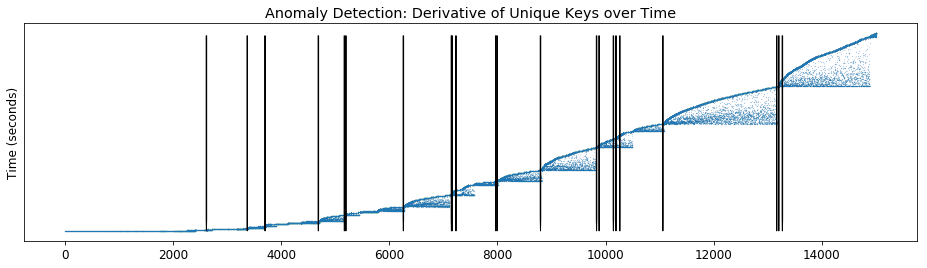

In [29]:
props = dict(facecolor='black', width=0.5, headwidth=0.5) # line properties
def AD_derivative(ax, dfs, key_tuple):
    plot_keyspace(ax, dfs, key_tuple)    
    d = dfs[key_tuple]['DF_KEY_TIMES']                # get the count df for this run
    d = d.drop_duplicates()                           # drop duplicates
    ts = int(d['ts'].head(1))                         # first timestep
    d['shift'] = d['ts'] - ts * np.ones(len(d['ts'])) # shift timestamps        
    d = d.groupby('shift').size().reset_index()       # unique keys over time
    d.columns=['shift', 'count']
    
    dy = np.diff(d['count'])/10                       # take the derivative
    for i in range(0, len(dy)):                       # if derivative is greater than some threshold
        if dy[i] > 3:
            ax.annotate("", xy=(i, 10), xytext=(i, 50000), arrowprops=props, ha="center")
    
    ax.set_title("Anomaly Detection: Derivative of Unique Keys over Time")
            
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
AD_derivative(ax, dfs, ("4 Node, 1M", "DBMemoryGet", "4"))

We can do better if we get a more accurate view of the current keyspace. Keys may be in one timestep but not the next. We want a window of the keyspace. We can then get larger magnitudes of "active keys".

              ts           op  dbkey                   key  shift
0     1504318792  DBMemoryGet      0  14045287823504495930    0.0
369   1504318793  DBMemoryGet      0  14045287823504495930    1.0
956   1504318794  DBMemoryGet      0  14045287823504495930    2.0
1476  1504318795  DBMemoryGet      0  14045287823504495930    3.0
2214  1504318796  DBMemoryGet      0  14045287823504495930    4.0


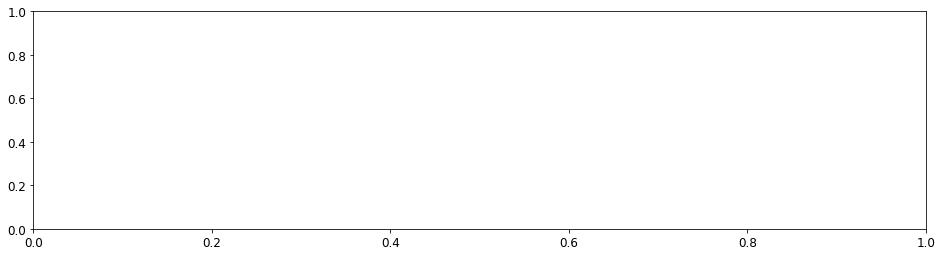

In [95]:
props = dict(facecolor='black', width=0.5, headwidth=0.5) # line properties
def AD_derivative_v1(ax, dfs, key_tuple):
    #plot_keyspace(ax, dfs, key_tuple)    
    input = dfs[key_tuple]['DF_KEY_TIMES']            # get the count df for this run
    input = input.drop_duplicates()                   # drop duplicates
    ts = int(input['ts'].head(1))                     # first timestep
    shift =  ts * np.ones(len(input['ts']))           # create array of initial timestamp
    input['shift'] = input['ts'] - shift              # shift timestamps
    input = input[input['shift'] < 8000]

    active   = {}  # active keyspace, where k = keyid, v = decay counter
    states   = []  # states in the current timestep
    state    = 1   # random state name
    ts       = 0.0 # current timestep 
    counts   = []  # array of counts
    for i in range(0, len(input)): # simulate, as if we are seeing events online
        d = input[input['shift' < i]]
        d = d.drop_duplicates()
        
        if ts != e['shift']: # if we are seeing a new ts
            # update keyspace
            for k, v in active.iterrows():
                if v # ALGORITHM: CHECK EACH KEY AND EVICT IF > 10 SECONDS
            # TAKE DERIVATIVE AND DETECT REGIME CHANGE
            counts.append(len(active))
            dy = np.diff(d_current['count'])/1        # take the derivative
            if dy[len(d)] > 3:
                print "found regime change"
                keyspace = {}
                
            ts = e['shift']
            
        states.append(e['key']) # add it to the current timestep
        i += 1.0
    return
               
    #for key in d['key']:                           
    #    if key not in states:
    #        states[key] = i
    #        i += 1            
    #    stateIDs.append(states[key])
    #d['id'] = stateIDs    
    
    #tss = {}                                          # get active keys
    #for _,e in d.iterrows():                          # for each timestep, get the active keys
    #    if e['shift'] not in tss:
    #        tss[e['shift']] = []
    #    tss[e['shift']].append(e['id'])
        
    d = d.groupby('shift').size().reset_index()       # unique keys over time
    d.columns=['shift', 'count']
    
    keyspace = []; i = 0
    for _,e in d.iterrows():                          # simulate (pretend we are seeing samples as they come in)
        if i != e['shift']:
            # process previous ts
            print "hi"
        d_current = d[d['shift'] < i]
        dy = np.diff(d_current['count'])/1            # take the derivative
        if dy[len(dy) - 1] > 3:
            print "empty cache at shift=" + str(i)
            keyspace = []
        
        
    #        ax.annotate("", xy=(i, 10), xytext=(i, 50000), arrowprops=props, ha="center")
    
    #ax.set_title("Anomaly Detection: Derivative of Unique Keys over Time")
            
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
AD_derivative_v1(ax, dfs, ("4 Node, 1M", "DBMemoryGet", "4"))